# Bag of Words Meets Bags of Popcorn

Bu projede kullanılan etiketli veri seti, duygu analizi için özel olarak seçilmiş 25000 IMDB film incelemesinden oluşmaktadır. İncelemelerin duygusu ikilidir, yani IMDB derecesi < 5 olduğunda duygu puanı 0 olur ve >=7 olduğunda duygu puanı 1 olur. Bu veri seti kullanılarak film hakkında yapılan yorumların `sentiment analizi`ni yapan model geliştirilmektedir.

Bu projede kullanılan veriler [buradan](https://www.kaggle.com/datasets/ymanojkumar023/kumarmanoj-bag-of-words-meets-bags-of-popcorn) temin edilmiştir.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
train=pd.read_csv("labeledTrainData.tsv", delimiter="\t", quoting=3)
test=pd.read_csv("testData.tsv", delimiter="\t", quoting=3)
df=pd.concat([train,test], ignore_index=True)

In [3]:
df.head()

,id,sentiment,review
0,"""5814_8""",1.0,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1.0,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0.0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0.0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1.0,"""Superbly trashy and wondrously unpretentious ..."


In [4]:
df.sentiment.value_counts()

sentiment
1.0    12500
0.0    12500
Name: count, dtype: int64

<Axes: ylabel='count'>

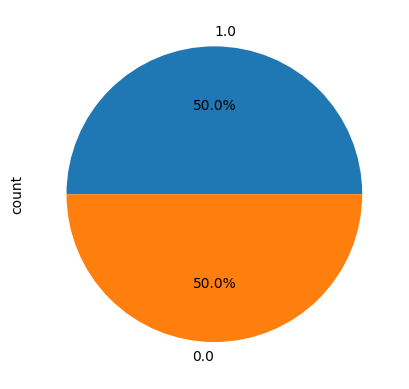

In [5]:
df["sentiment"].value_counts().plot.pie(autopct="%1.1f%%")

### Metin Temizleme

In [6]:
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from nltk.stem import PorterStemmer
pr=PorterStemmer()

In [7]:
def clean_text(text):
    #text = BeautifulSoup(text).get_text() 
    text=text.str.lower()
    text=text.str.replace('[^\w\s]', '', regex=True)
    text=text.str.replace('\d+', '', regex=True)
    text=text.str.replace('\n', '', regex=True)
    text=text.str.replace('\r', '', regex=True)
    return text

In [8]:
def lemmafn(text):
    words=TextBlob(text).words
    return [pr.stem(word) for word in words]

In [9]:
vect=CountVectorizer(stop_words="english", ngram_range=(1,2), analyzer=lemmafn, max_features=80000)

### ML Modelleme

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

b = BernoulliNB()
l = LogisticRegression()
d = DecisionTreeClassifier()
r = RandomForestClassifier()
gb= GradientBoostingClassifier()
kn= KNeighborsClassifier()
ab= AdaBoostClassifier()
mn= MultinomialNB()

def algo_test(x, y):
    modeller=[ b, l, d, r, gb, kn, ab, mn]
    isimler=["BernoulliNB", "LogisticRegression", "DecisionTreeClassifier", 
             "RandomForestClassifier", "GradientBoostingClassifier", "KNeighborsClassifier",
             "AdaBoostClassifier", "MultinomialNB"]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state = 42)
    
    accuracy = []
    precision = []
    recall = []
    f1 = []
    mdl=[]

    print("Veriler hazır modeller deneniyor")
    for model in modeller:
        print(model, " modeli eğitiliyor!..")
        model=model.fit(x_train,y_train)
        tahmin=model.predict(x_test)
        mdl.append(model)
        accuracy.append(accuracy_score(y_test, tahmin))
        precision.append(precision_score(y_test, tahmin, average="micro"))
        recall.append(recall_score(y_test, tahmin, average="micro"))
        f1.append(f1_score(y_test, tahmin, average="micro"))
        print(confusion_matrix(y_test, tahmin))

    print("Eğitim tamamlandı.")
    
    metrics=pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1", "Model"], index=isimler)
    metrics["Accuracy"] = accuracy
    metrics["Precision"] = precision  
    metrics["Recall"] = recall
    metrics["F1"] = f1
    metrics["Model"]=mdl

    metrics.sort_values("F1", ascending=False, inplace=True)

    print("En başarılı model: ", metrics.iloc[0].name)
    model=metrics.iloc[0,-1]
    tahmin=model.predict(np.array(x_test) if model==kn else x_test)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, tahmin))
    print("classification Report:")
    print(classification_report(y_test, tahmin))
    print("Diğer Modeller:")
    
    return metrics.drop("Model", axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         50000 non-null  object 
 1   sentiment  25000 non-null  float64
 2   review     50000 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [12]:
df["review"]=clean_text(df["review"])

In [13]:
train=df.iloc[:25000]
test=df.iloc[25000:]

In [14]:
x=np.array(train["review"])
y=np.array(train["sentiment"])

In [15]:
x=vect.fit_transform(x)

In [16]:
algo_test(x,y)

Veriler hazır modeller deneniyor
BernoulliNB()  modeli eğitiliyor!..
[[3282  456]
 [ 655 3107]]
LogisticRegression()  modeli eğitiliyor!..
[[3267  471]
 [ 469 3293]]
DecisionTreeClassifier()  modeli eğitiliyor!..
[[2643 1095]
 [1138 2624]]
RandomForestClassifier()  modeli eğitiliyor!..
[[3134  604]
 [ 594 3168]]
GradientBoostingClassifier()  modeli eğitiliyor!..
[[2872  866]
 [ 520 3242]]
KNeighborsClassifier()  modeli eğitiliyor!..
[[1999 1739]
 [1067 2695]]
AdaBoostClassifier()  modeli eğitiliyor!..
[[2903  835]
 [ 622 3140]]
MultinomialNB()  modeli eğitiliyor!..
[[3257  481]
 [ 687 3075]]
Eğitim tamamlandı.
En başarılı model:  LogisticRegression
Confusion Matrix:
[[3267  471]
 [ 469 3293]]
classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87      3738
         1.0       0.87      0.88      0.88      3762

    accuracy                           0.87      7500
   macro avg       0.87      0.87      0.87      7500
wei

,Accuracy,Precision,Recall,F1
LogisticRegression,0.874667,0.874667,0.874667,0.874667
BernoulliNB,0.851867,0.851867,0.851867,0.851867
MultinomialNB,0.844267,0.844267,0.844267,0.844267
RandomForestClassifier,0.840267,0.840267,0.840267,0.840267
GradientBoostingClassifier,0.815200,0.815200,0.815200,0.815200
AdaBoostClassifier,0.805733,0.805733,0.805733,0.805733
DecisionTreeClassifier,0.702267,0.702267,0.702267,0.702267
KNeighborsClassifier,0.625867,0.625867,0.625867,0.625867


In [17]:
lr=LogisticRegression()
lr_model=lr.fit(x, y)

In [18]:
test.head()

,id,sentiment,review
25000,"""12311_10""",NaN,naturally in a film whos main themes are of mo...
25001,"""8348_2""",NaN,this movie is a disaster within a disaster fil...
25002,"""5828_4""",NaN,all in all this is a movie for kids we saw it ...
25003,"""7186_2""",NaN,afraid of the dark left me with the impression...
25004,"""12128_7""",NaN,a very accurate depiction of small time mob li...


In [19]:
x_test=np.array(test["review"])

In [20]:
x_test=vect.fit_transform(x_test)

In [21]:
test["sentiment"]=lr_model.predict(x_test)

In [22]:
test.head()

,id,sentiment,review
25000,"""12311_10""",1.0,naturally in a film whos main themes are of mo...
25001,"""8348_2""",0.0,this movie is a disaster within a disaster fil...
25002,"""5828_4""",1.0,all in all this is a movie for kids we saw it ...
25003,"""7186_2""",1.0,afraid of the dark left me with the impression...
25004,"""12128_7""",0.0,a very accurate depiction of small time mob li...


### DL Modelleme

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [35]:
x = train['review'].values
y = train['sentiment'].values

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [37]:
tokenizer = Tokenizer(num_words=10000) 
tokenizer.fit_on_texts(x_train)

In [38]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [39]:
# Ardışıl dizeleri aynı uzunluğa (maksimum dizi uzunluğuna) getirin
max_sequence_length = max([len(x) for x in x_train])
x_train = pad_sequences(x_train, maxlen=max_sequence_length)
x_test = pad_sequences(x_test, maxlen=max_sequence_length)

In [40]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=100, input_length=max_sequence_length))
model.add(LSTM(128))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
625/625 [==============================] - 152s 236ms/step - loss: 0.4845 - accuracy: 0.7717 - val_loss: 0.3759 - val_accuracy: 0.8420
Epoch 2/10
625/625 [==============================] - 147s 236ms/step - loss: 0.2984 - accuracy: 0.8809 - val_loss: 0.3295 - val_accuracy: 0.8684
Epoch 3/10
625/625 [==============================] - 150s 240ms/step - loss: 0.1908 - accuracy: 0.9286 - val_loss: 0.3509 - val_accuracy: 0.8614
Epoch 4/10
625/625 [==============================] - 149s 238ms/step - loss: 0.1408 - accuracy: 0.9484 - val_loss: 0.3860 - val_accuracy: 0.8492
Epoch 5/10
625/625 [==============================] - 148s 237ms/step - loss: 0.0925 - accuracy: 0.9675 - val_loss: 0.5851 - val_accuracy: 0.8618
Epoch 6/10
625/625 [==============================] - 148s 238ms/step - loss: 0.0968 - accuracy: 0.9629 - val_loss: 0.4674 - val_accuracy: 0.8276
Epoch 7/10
625/625 [==============================] - 150s 240ms/step - loss: 0.0699 - accuracy: 0.9765 - val_loss: 0.6337 -

In [42]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

157/157 [==============================] - 12s 77ms/step - loss: 0.7186 - accuracy: 0.8424
Test Loss: 0.7186
Test Accuracy: 0.8424


In [43]:
xt=test['review'].values

In [44]:
xt = tokenizer.texts_to_sequences(xt)

In [45]:
xt = pad_sequences(xt, maxlen=max_sequence_length)

In [47]:
pred=model.predict(xt)

782/782 [==============================] - 74s 95ms/step


In [50]:
pred

array([[7.5863610e-04, 9.9924135e-01],
       [9.9974912e-01, 2.5087612e-04],
       [9.6456313e-01, 3.5436880e-02],
       ...,
       [9.9978906e-01, 2.1096028e-04],
       [1.1100903e-05, 9.9998891e-01],
       [9.9551433e-01, 4.4857012e-03]], dtype=float32)

In [51]:
pred2=[np.argmax(x) for x in pred]

In [52]:
pred2

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,


In [53]:
test["sentiment_dl"]=pred2

In [54]:
test.head()

,id,sentiment,review,sentiment_dl
25000,"""12311_10""",1.0,naturally in a film whos main themes are of mo...,1
25001,"""8348_2""",0.0,this movie is a disaster within a disaster fil...,0
25002,"""5828_4""",1.0,all in all this is a movie for kids we saw it ...,0
25003,"""7186_2""",1.0,afraid of the dark left me with the impression...,0
25004,"""12128_7""",0.0,a very accurate depiction of small time mob li...,0


In [58]:
test.iloc[2]["review"]

'all in all this is a movie for kids we saw it tonight and my child loved it at one point my kids excitement was so great that sitting was impossible however i am a great fan of aa milnes books which are very subtle and hide a wry intelligence behind the childlike quality of its leading characters this film was not subtle it seems a shame that disney cannot see the benefit of making movies from more of the stories contained in those pages although perhaps it doesnt have the permission to use them i found myself wishing the theater was replaying winniethepooh and tigger too instead the characters voices were very good i was only really bothered by kanga the music however was twice as loud in parts than the dialog and incongruous to the filmbr br as for the story it was a bit preachy and militant in tone overall i was disappointed but i would go again just to see the same excitement on my childs facebr br i liked lumpys laugh'

In [65]:
import csv
test[["id", "sentiment_dl"]].to_csv("submission.csv", quoting=csv.QUOTE_NONE, quotechar='', index=False)

## Sonuç

Bu projede eski bir Kaggle yarışması verileri kullanılarak IMDB film yorumlarının sentiment analizini yapacak derin öğrenme sınıflandırma modeli geliştirilmiştir.